In [6]:
import pickle, gzip, math, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tqdm # a package for making progress bar

# $\color{Orange}{\text{Load Data}}$

In [2]:
def loadData(src):
    '''
    return: train_x - 2D Numpy array (n, d) where each row is an image
            train_y - 1D Numpy array (n, ) where each row is a label
            test_x  - 2D Numpy array (n, d) where each row is an image
            test_y  - 1D Numpy array (n, ) where each row is a label
    '''
    f = gzip.open(src, 'rb')
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
    f.close()
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    test_x, test_y = test_set
    print('Originally, train len (n): '+str(len(train_y))+'  '+'valid len (n): '+str(len(valid_y))+'  '+'test len (n): '+str(len(test_y)))
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    print('Now, train len (n): '+str(len(train_y))+'  '+'test len (n): '+str(len(test_y)))
    print('Each vec len (p): '+str(train_x.shape[1]))
    return (train_x, train_y, test_x, test_y)

In [19]:
def loadOverlapData(path_to_data_dir, use_mini_dataset, img_rows=42, img_cols=28):
    '''
    paras: path_to_data_dir - String
           use_mini_dataset - Boolean
           img_rows, img_cols - int - define the size of an image
    '''
    if use_mini_dataset:
        exten = '_mini'
    else:
        exten = ''
    f = gzip.open(path_to_data_dir + 'train_multi_digit' + exten + '.pkl.gz', 'rb')
    X_train = pickle.load(f, encoding='latin1')
    f.close()
    X_train =  np.reshape(X_train, (len(X_train), 1, img_rows, img_cols))
    
    f = gzip.open(path_to_data_dir + 'test_multi_digit' + exten +'.pkl.gz', 'rb')
    X_test = pickle.load(f, encoding='latin1')
    f.close()
    X_test =  np.reshape(X_test, (len(X_test),1, img_rows, img_cols))
    
    f = gzip.open(path_to_data_dir + 'train_labels' + exten +'.txt.gz', 'rb')
    y_train = np.loadtxt(f)
    f.close()
    
    f = gzip.open(path_to_data_dir +'test_labels' + exten + '.txt.gz', 'rb')
    y_test = np.loadtxt(f)
    f.close()
    
    print('X_Train shape: '+str(X_train.shape)+'  '+'y_train shape: '+str(y_train.shape))
    print('X_Test shape: '+str(X_test.shape)+'  '+'y_test shape: '+str(y_test.shape))
    return X_train, y_train, X_test, y_test

In [295]:
def plotImg(X,n=0,p=0):
    '''
    return: image(s) with n rows & p cols
    '''
    num_images = X.shape[0]
    if n == 0 & p == 0:
        num_rows = math.floor(math.sqrt(num_images)) # floor: 2.5 -> 2
        num_cols = math.ceil(num_images/num_rows) # ceil: 2.5 -> 3
    else:
        if n*p < num_images:
            return print("Wrong n, p values")
        num_rows, num_cols = n, p
    plt.figure(figsize=(20,10))
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()

# $\color{Orange}{\text{Preprocess Data}}$

In [118]:
# Split into train and dev
def splitData(X, y, is_overlap):
    split_index = int(9 * len(X) / 10)
    
    X_train, X_dev = X[:split_index], X[split_index:]        # 9/10 train set -> n = 54000
    if is_overlap:
        y_train = [y[0][:split_index], y[1][:split_index]]
        y_dev = [y[0][split_index:], y[1][split_index:]]
    else:
        y_train, y_dev = y[:split_index], y[split_index:]    # 1/10 dev set -> n = 6000

    permutation = np.array([i for i in range(len(X_train))]) # an array of nums from 0 to 54000
    np.random.shuffle(permutation)                           # shuffle so as to reorder the data points
    X_train = [X_train[i] for i in permutation]
    if is_overlap:
        y_train = [[y_train[0][i] for i in permutation], [y_train[1][i] for i in permutation]] 
    else:
        y_train = [y_train[i] for i in permutation]
    return X_train, y_train, X_dev, y_dev

In [265]:
def batchifyData(X, y, batch_size, is_overlap):
    """
    Takes a set of data points and labels and groups them into batches.
    
    paras: X - a list of inputs; 
           y - a list of outputs; 
           batch_size - String - how many data points in each batch
           is_overlap - Boolean - whether two digits overlap in an img
    
    return: a list of dict 
            [{'x': tensor(mat1,...,matn), 'y': tensor(num1,...,numn)}, ...]
    """
    # Only take batch_size chunks. The remainder will be dropped.
    N = int(len(X) / batch_size) * batch_size # how many batches we have
    batches = []
    for i in range(0, N, batch_size):
        if is_overlap:
            batches.append({
                'x': torch.tensor(X[i:i+batch_size], dtype=torch.float32),
                'y': torch.tensor([y[0][i:i + batch_size],
                                   y[1][i:i + batch_size]],
                                   dtype=torch.int64)
            })
        else:
            batches.append({
                'x': torch.tensor(X[i:i+batch_size], dtype=torch.float32),
                'y': torch.tensor(y[i:i+batch_size], dtype=torch.long
            )})
    return batches

In [10]:
# How a batch looks like
train_batches[0]

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'y': tensor([2, 1, 1, 4, 4, 4, 9, 1, 0, 1, 1, 9, 3, 9, 0, 1, 3, 1, 3, 2, 8, 4, 9, 9,
         8, 7, 1, 6, 3, 0, 3, 9])}

# $\color{Orange}{\text{Modeling}}$

In [342]:
def trainModel(train_data, dev_data, model, optimizer, is_overlap, n_epochs):
    """
    Train a model for N epochs given data and hyper-params.
    
    return: a list of dictionary with [{'Train Loss','Validation Loss'},{'Train Accuracy','Validation Accuracy'}]
    """
    train_losses, train_accuracies, val_losses, val_accuracies = [],[],[],[]
    
    for epoch in tqdm.tqdm(range(1, n_epochs+1)):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Run **training***
        train_loss, train_acc, train_errors = runEpoch(train_data, model.train(), optimizer, is_overlap)
        # Run **validation**
        val_loss, val_acc, val_errors = runEpoch(dev_data, model.eval(), optimizer, is_overlap)
        
        if is_overlap:
            print('Train | loss1: {:.6f}  accuracy1: {:.6f} | loss2: {:.6f}  accuracy2: {:.6f}'.format(train_loss[0], train_acc[0], train_loss[1], train_acc[1]))
            print('Valid | loss1: {:.6f}  accuracy1: {:.6f} | loss2: {:.6f}  accuracy2: {:.6f}'.format(val_loss[0], val_acc[0], val_loss[1], val_acc[1]))
        else:
            print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(train_loss, train_acc))
            print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
        
#     if is_overlap:
#         return [{'Train loss1':train_losses[0],'Validation loss1':val_losses[0]},
#                 {'Train loss2':train_losses[1],'Validation loss2':val_losses[1]},
#                 {'Train accuracy1':train_accuracies[0],'Validation accuracy1':val_accuracies[0]},
#                 {'Train accuracy2':train_accuracies[1],'Validation accuracy2':val_accuracies[1]}]
#     else:
    return [{'Train loss':train_losses,'Validation loss':val_losses},
            {'Train accuracy':train_accuracies,'Validation accuracy':val_accuracies}]

In [314]:
def runEpoch(data, model, optimizer, is_overlap):
    """Train model for one pass of train data, and return loss, acccuracy"""
    if is_overlap:
        # Gather losses
        losses_first_label = []
        losses_second_label = []
        batch_accuracies_first = []
        batch_accuracies_second = []
        x_err, y1_err, y2_err, pred1_err, pred2_err = [],[],[],[],[]

        # If model is in train mode, use optimizer.
        is_training = model.training

        # Iterate through batches
        for batch in data:
            # Grab x and y
            x, y = batch['x'], batch['y']

            # Get output predictions
            out1, out2 = model(x)

            # Predict and store accuracy
            predictions_first_label = torch.argmax(out1, dim=1)
            predictions_second_label = torch.argmax(out2, dim=1)

            bool_arr1 = (predictions_first_label == y[0])
            bool_arr2 = (predictions_second_label == y[1])
            bool_arr = torch.tensor([1-(i[0]|i[1]) for i in zip(bool_arr1, bool_arr2)],dtype=torch.uint8)

            # collect data with wrong predicted label
            ## need to convert pytorch tensor to list so as to append
            x_err += x[bool_arr].tolist()
            y1_err += y[0][bool_arr].tolist()
            y2_err += y[1][bool_arr].tolist()
            pred1_err += predictions_first_label[bool_arr].tolist()
            pred2_err += predictions_second_label[bool_arr].tolist()
            
            ## need to convert pytorch tensor to numpy array so as to apply np funcs
            accuracy1 = np.mean(bool_arr1.numpy())
            accuracy2 = np.mean(bool_arr2.numpy())
            batch_accuracies_first.append(accuracy1)
            batch_accuracies_second.append(accuracy2)

            # Compute loss
            loss1 = F.cross_entropy(out1, y[0])
            loss2 = F.cross_entropy(out2, y[1])
            losses_first_label.append(loss1.data.item())
            losses_second_label.append(loss2.data.item())

            # If training, do an update.
            if is_training:
                optimizer.zero_grad()
                joint_loss = 0.5 * (loss1 + loss2)
                joint_loss.backward()
                optimizer.step()

        # Calculate epoch level scores
        errors = (x_err, y1_err, y2_err, pred1_err, pred2_err)
        avg_loss = np.mean(losses_first_label), np.mean(losses_second_label)
        avg_accuracy = np.mean(batch_accuracies_first), np.mean(batch_accuracies_second)
        
    else:
        # Gather losses
        losses = []
        batch_accuracies = []
        x_err, y_err, pred_err = [],[],[]

        # If model is in train mode, use optimizer.
        is_training = model.training

        # Iterate through batches
        for batch in data:
            # Grab x and y
            x, y = batch['x'], batch['y']

            # Get output predictions
            out = model(x)

            # Predict and store accuracy
            predictions = torch.argmax(out, dim=1)

            bool_arr = (predictions == y)

            # collect data with wrong predicted label
            ## need to convert pytorch tensor to list so as to append
            x_err += x[1-bool_arr].tolist()
            y_err += y[1-bool_arr].tolist()
            pred_err += predictions[1-bool_arr].tolist()
            ## need to convert pytorch tensor to numpy array so as to apply np funcs
            accuracy = np.mean(bool_arr.numpy())
            batch_accuracies.append(accuracy)

            # Compute loss
            loss = F.cross_entropy(out, y)
            losses.append(loss.data.item())

            # If training, do an update.
            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Calculate epoch level scores
        avg_loss = np.mean(losses)
        avg_accuracy = np.mean(batch_accuracies)
        errors = (x_err, y_err, pred_err)
        
    return avg_loss, avg_accuracy, errors

In [34]:
class Flatten(nn.Module):
    """A custom layer that views an input as 1D."""
    def forward(self, input):
        return input.view(input.size(0), -1)

# $\color{Orange}{\text{Utilities}}$

In [19]:
def processData(algo):
    '''
    return: a list of dictionary with [{'Train Loss','Validation Loss'},{'Train Accuracy','Validation Accuracy'}]
            a float - test loss
            a float - test accuracy
            a tuple - 3 lists - test x errors, test y errors, test pred errors
    '''
    if algo == 'FFNN':  # each image is a flattened vector
        X_train_dev_ = X_train_dev
        X_test_ = X_test
    elif algo == 'CNN':  # need to rehape the data back into a 1x28x28 image
        X_train_dev_ = np.reshape(X_train_dev, (X_train_dev.shape[0], 1, 28, 28))
        X_test_ = np.reshape(X_test, (X_test.shape[0], 1, 28, 28))
    
    # Split into train and dev
    X_train, y_train, X_dev, y_dev = splitData(X_train_dev_,y_train_dev)
    
    # Split dataset into batches
    train_batches = batchifyData(X_train, y_train, batch_size)
    dev_batches = batchifyData(X_dev, y_dev, batch_size)
    test_batches = batchifyData(X_test_, y_test, batch_size)
    
    # train model
    train_dev_loss_acc = train_model(train_batches, dev_batches, model, lr=lr, momentum=momentum, nesterov=nesterov, n_epochs=n_epochs)
    
    # Evaluate the model on test data
    test_loss, test_acc, test_errors = run_epoch(test_batches, model.eval(), None)
    print()
    print("Loss on test set:"  + str(test_loss) + " Accuracy on test set: " + str(test_acc))
    return train_dev_loss_acc, test_loss, test_acc, test_errors

In [319]:
# def plotRes(res_dict,title):
#     for key, values in res_dict.items():
#         plt.plot(values, marker='o', markersize=5, label=key)
#     plt.legend()
#     plt.title(title)
def plotRes(train_dev_loss_acc):
    fig, axs = plt.subplots(1, len(train_dev_loss_acc), figsize=(20,5))
    for i in range(len(train_dev_loss_acc)):
        title = []
        for key, values in train_dev_loss_acc[i].items():
            axs[i].plot(values, marker='o', markersize=5, label=key)
            title.append(key)
        axs[i].set_title(' vs '.join(title), fontsize=20)
        axs[i].set_xlabel('n epochs',fontsize=12)
        axs[i].legend(fontsize=15)

# $\color{Orange}{\text{Set Parameters & Run Model}}$

In [77]:
np.random.seed(12321)  # for reproducibility
torch.manual_seed(12321)  # for reproducibility
X_train_dev, y_train_dev, X_test, y_test = loadData('mnist.pkl.gz')

Originally, train len (n): 50000  valid len (n): 10000  test len (n): 10000
Now, train len (n): 60000  test len (n): 10000
Each vec len (p): 784


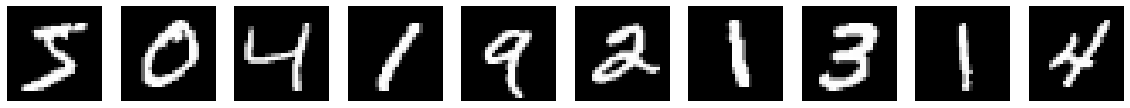

In [158]:
plotImg(X_train_dev[:10],1,10)

In [13]:
# Model specification
batch_size = 128

## Hidden Layer Representation Size
unit_size = 128

## FFNN Model
ffnn = nn.Sequential(
    nn.Linear(784, unit_size),
    nn.LeakyReLU(),
    nn.Linear(unit_size, 10)
)

## CNN Model
cnn = nn.Sequential(
    nn.Conv2d(1, 32, (3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),
    nn.Conv2d(32, 64, (3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    Flatten(),
    nn.Linear(1600,unit_size),
    nn.Dropout(),
    nn.Linear(unit_size,10)
)

model = cnn        
lr = 0.1
momentum = 0.9
nesterov = False
n_epochs = 20

In [20]:
# test accuracy = 0.9204727564102564 when batch size = 128 lr = 0.1
train_dev_loss_acc, test_loss, test_acc, test_errors = processData('CNN')

  0%|          | 0/20 [00:00<?, ?it/s]

-------------
Epoch 1:

Train loss: 0.237640 | Train accuracy: 0.923972


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
  5%|▌         | 1/20 [00:45<14:29, 45.76s/it]

Val loss:   0.059037 | Val accuracy:   0.982167
-------------
Epoch 2:

Train loss: 0.071837 | Train accuracy: 0.978492


 10%|█         | 2/20 [01:32<13:50, 46.16s/it]

Val loss:   0.051500 | Val accuracy:   0.986073
-------------
Epoch 3:

Train loss: 0.057147 | Train accuracy: 0.982594


 15%|█▌        | 3/20 [02:23<13:29, 47.62s/it]

Val loss:   0.049102 | Val accuracy:   0.986923
-------------
Epoch 4:

Train loss: 0.049655 | Train accuracy: 0.984208


 20%|██        | 4/20 [03:12<12:45, 47.83s/it]

Val loss:   0.044436 | Val accuracy:   0.986753
-------------
Epoch 5:

Train loss: 0.042500 | Train accuracy: 0.985804


 25%|██▌       | 5/20 [03:59<11:56, 47.77s/it]

Val loss:   0.040059 | Val accuracy:   0.989300
-------------
Epoch 6:

Train loss: 0.041394 | Train accuracy: 0.987270


 30%|███       | 6/20 [04:47<11:10, 47.87s/it]

Val loss:   0.054284 | Val accuracy:   0.985904
-------------
Epoch 7:

Train loss: 0.041760 | Train accuracy: 0.987047


 35%|███▌      | 7/20 [05:41<10:42, 49.44s/it]

Val loss:   0.043529 | Val accuracy:   0.988281
-------------
Epoch 8:

Train loss: 0.038384 | Train accuracy: 0.987585


 40%|████      | 8/20 [06:27<09:42, 48.53s/it]

Val loss:   0.049260 | Val accuracy:   0.987942
-------------
Epoch 9:

Train loss: 0.037918 | Train accuracy: 0.988272


 45%|████▌     | 9/20 [07:19<09:06, 49.64s/it]

Val loss:   0.049413 | Val accuracy:   0.988621
-------------
Epoch 10:

Train loss: 0.038242 | Train accuracy: 0.988569


 50%|█████     | 10/20 [08:12<08:25, 50.54s/it]

Val loss:   0.051074 | Val accuracy:   0.988111
-------------
Epoch 11:

Train loss: 0.035417 | Train accuracy: 0.989311


 55%|█████▌    | 11/20 [08:57<07:20, 48.98s/it]

Val loss:   0.062016 | Val accuracy:   0.986413
-------------
Epoch 12:

Train loss: 0.037502 | Train accuracy: 0.988847


 60%|██████    | 12/20 [09:49<06:38, 49.78s/it]

Val loss:   0.050170 | Val accuracy:   0.988791
-------------
Epoch 13:

Train loss: 0.033152 | Train accuracy: 0.990035


 65%|██████▌   | 13/20 [10:38<05:47, 49.65s/it]

Val loss:   0.042065 | Val accuracy:   0.989470
-------------
Epoch 14:

Train loss: 0.029969 | Train accuracy: 0.991297


 70%|███████   | 14/20 [11:28<04:59, 49.86s/it]

Val loss:   0.068852 | Val accuracy:   0.984885
-------------
Epoch 15:

Train loss: 0.033406 | Train accuracy: 0.989924


 75%|███████▌  | 15/20 [12:18<04:08, 49.68s/it]

Val loss:   0.074907 | Val accuracy:   0.987772
-------------
Epoch 16:

Train loss: 0.037003 | Train accuracy: 0.989627


 80%|████████  | 16/20 [13:05<03:15, 48.96s/it]

Val loss:   0.070794 | Val accuracy:   0.987432
-------------
Epoch 17:

Train loss: 0.037166 | Train accuracy: 0.989719


 85%|████████▌ | 17/20 [13:55<02:28, 49.34s/it]

Val loss:   0.057875 | Val accuracy:   0.988451
-------------
Epoch 18:

Train loss: 0.042767 | Train accuracy: 0.988476


 90%|█████████ | 18/20 [14:43<01:37, 48.93s/it]

Val loss:   0.057928 | Val accuracy:   0.989470
-------------
Epoch 19:

Train loss: 0.037192 | Train accuracy: 0.989812


 95%|█████████▌| 19/20 [15:29<00:48, 48.04s/it]

Val loss:   0.056149 | Val accuracy:   0.988621
-------------
Epoch 20:

Train loss: 0.036644 | Train accuracy: 0.989552


100%|██████████| 20/20 [16:17<00:00, 47.96s/it]

Val loss:   0.076878 | Val accuracy:   0.987432



Loss on test set:0.06167009219718285 Accuracy on test set: 0.9871794871794872


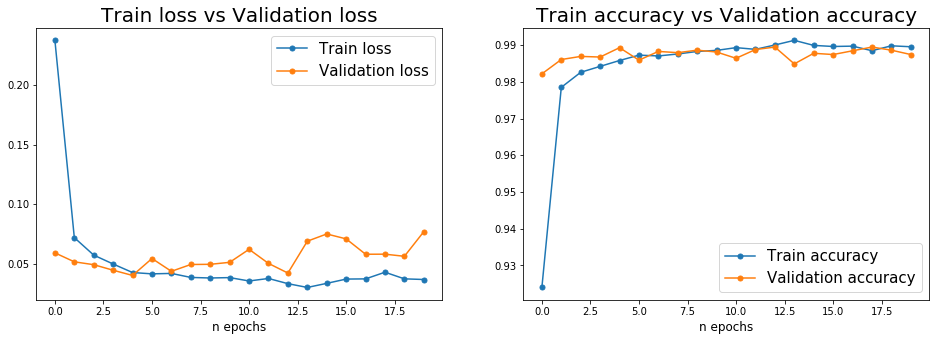

In [61]:
plotRes(train_dev_loss_acc) 

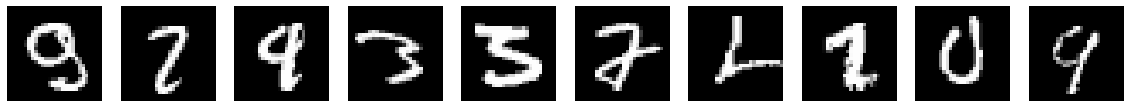

True labels:              [9 2 9 3 3 2 2 2 0 9]
Wrongly Predicted labels: [8 7 4 7 5 7 6 1 4 7]
Wrong labels in total:    128


In [70]:
plotImg(np.array(test_errors[0])[:10],1,10)
print('True labels:              '+str(np.array(test_errors[1])[:10]))
print('Wrongly Predicted labels: '+str(np.array(test_errors[2])[:10]))
print('Wrong labels in total:    '+str(len(test_errors[2])))

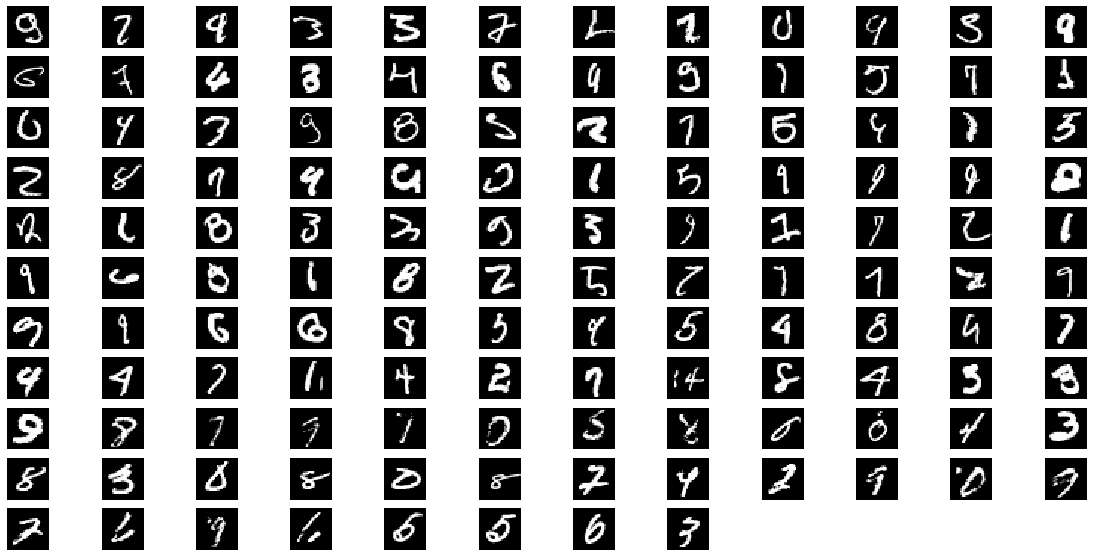

True labels:              [9 2 9 3 3 2 2 2 0 9 3 8 6 7 4 3 4 6 9 9 7 5 7 1 0 4 3 9 8 5 2 7 5 9 1 5 2
 8 7 4 9 0 1 5 9 9 9 2 2 6 8 3 3 9 3 9 1 7 2 1 9 6 5 1 8 2 5 7 7 7 2 9 9 9
 6 6 8 3 9 5 4 8 9 7 4 4 7 1 4 2 7 4 8 4 5 3 9 8 7 9 7 0 5 8 0 0 4 3 8 3 0
 8 0 8 7 4 2 9 0 9 2 6 9 6 5 5 6 3]
Wrongly Predicted labels: [8 7 4 7 5 7 6 1 4 7 5 9 5 1 6 2 7 5 4 5 1 7 1 5 6 7 7 5 0 7 7 1 0 4 2 3 7
 4 9 9 4 2 6 7 1 4 4 0 7 1 0 8 7 5 5 5 7 1 6 6 1 4 0 6 0 7 0 2 1 1 7 7 7 1
 5 8 9 5 4 6 9 0 4 2 9 9 2 6 1 8 9 7 5 7 3 8 5 5 1 7 1 7 2 2 8 6 1 2 5 5 6
 5 2 5 2 8 7 7 1 7 7 1 7 1 6 0 0 7]
Wrong labels in total:    128


In [71]:
plotImg(np.array(test_errors[0]))
print('True labels:              '+str(np.array(test_errors[1])))
print('Wrongly Predicted labels: '+str(np.array(test_errors[2])))
print('Wrong labels in total:    '+str(len(test_errors[2])))

In [78]:
# Model specification
batch_size = 32

unit_size = 10

## FFNN Model
ffnn = nn.Sequential(
    nn.Linear(784, unit_size),
    nn.LeakyReLU(),
    nn.Linear(unit_size, 10)
)

model = ffnn        
lr = 0.1
n_epochs = 10

In [79]:
# Baseline
train_dev_loss_acc, test_loss, test_acc, test_errors = processData('FFNN')

  0%|          | 0/10 [00:00<?, ?it/s]

-------------
Epoch 1:



 10%|█         | 1/10 [00:03<00:28,  3.16s/it]

Train loss: 0.582855 | Train accuracy: 0.836063
Val loss:   0.426959 | Val accuracy:   0.890374
-------------
Epoch 2:



 20%|██        | 2/10 [00:06<00:26,  3.32s/it]

Train loss: 0.441273 | Train accuracy: 0.883039
Val loss:   0.411276 | Val accuracy:   0.894218
-------------
Epoch 3:



 30%|███       | 3/10 [00:09<00:22,  3.15s/it]

Train loss: 0.406651 | Train accuracy: 0.892579
Val loss:   0.378749 | Val accuracy:   0.900735
-------------
Epoch 4:



 40%|████      | 4/10 [00:12<00:18,  3.03s/it]

Train loss: 0.392491 | Train accuracy: 0.897951
Val loss:   0.439507 | Val accuracy:   0.894886
-------------
Epoch 5:

Train loss: 0.374905 | Train accuracy: 0.903823


 50%|█████     | 5/10 [00:15<00:16,  3.21s/it]

Val loss:   0.446073 | Val accuracy:   0.905414
-------------
Epoch 6:



 60%|██████    | 6/10 [00:19<00:12,  3.19s/it]

Train loss: 0.372095 | Train accuracy: 0.905880
Val loss:   0.389105 | Val accuracy:   0.901738
-------------
Epoch 7:



 70%|███████   | 7/10 [00:22<00:09,  3.11s/it]

Train loss: 0.367164 | Train accuracy: 0.906750
Val loss:   0.373776 | Val accuracy:   0.905080
-------------
Epoch 8:



 80%|████████  | 8/10 [00:25<00:06,  3.15s/it]

Train loss: 0.356523 | Train accuracy: 0.908899
Val loss:   0.382020 | Val accuracy:   0.911932
-------------
Epoch 9:



 90%|█████████ | 9/10 [00:27<00:03,  3.01s/it]

Train loss: 0.364375 | Train accuracy: 0.907750
Val loss:   0.575103 | Val accuracy:   0.894552
-------------
Epoch 10:



100%|██████████| 10/10 [00:30<00:00,  2.92s/it]

Train loss: 0.352388 | Train accuracy: 0.912270
Val loss:   0.312012 | Val accuracy:   0.923964



Loss on test set:0.3792180856689811 Accuracy on test set: 0.9125600961538461


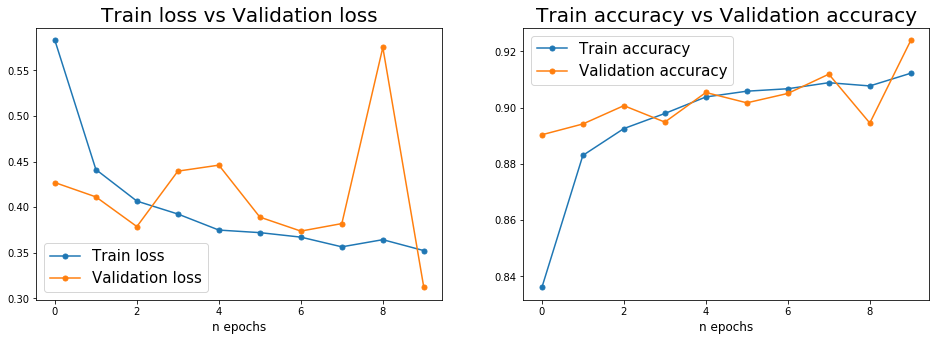

In [80]:
plotRes(train_dev_loss_acc) 

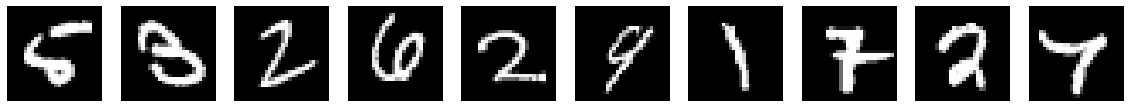

True labels:              [5 3 2 6 2 9 1 7 2 7]
Wrongly Predicted labels: [6 8 3 7 8 4 9 3 8 4]
Wrong labels in total:    873


In [81]:
plotImg(np.array(test_errors[0])[:10],1,10)
print('True labels:              '+str(np.array(test_errors[1])[:10]))
print('Wrongly Predicted labels: '+str(np.array(test_errors[2])[:10]))
print('Wrong labels in total:    '+str(len(test_errors[2])))

<br><br><br><br><br>
# $\color{Orange}{\text{Overlapping Digits}}$

In [310]:
num_classes = 10
img_rows, img_cols = 42, 28

In [311]:
class MLP(nn.Module):

    def __init__(self, input_dimension):
        super(MLP, self).__init__()
        self.flatten = Flatten()
        # initialize model layers here
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64,64)
        self.linear_first_digit = nn.Linear(64, num_classes)
        self.linear_second_digit = nn.Linear(64, num_classes)

    def forward(self, x):
        xf = self.flatten(x)

        # use model layers to predict the two digits
        out1 = F.relu(self.linear1(xf))
        out2 = F.relu(self.linear2(out1))
        out_first_digit = self.linear_first_digit(out2)
        out_second_digit = self.linear_second_digit(out2)

        return out_first_digit, out_second_digit

In [312]:
class CNN(nn.Module):

    def __init__(self, input_dimension):
        super(CNN, self).__init__()
        # initialize model layers here
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64,64)
        self.linear_first_digit = nn.Linear(64,num_classes)
        self.linear_second_digit = nn.Linear(64, num_classes)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8,(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(8,16,(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            Flatten(),
            nn.Linear(720,128),
            nn.Dropout(0.5)
        )
        
        self.first_digit_class = nn.Linear(128,10)
        self.second_digit_class = nn.Linear(128,10)

    def forward(self, x):

        # use model layers to predict the two digits
        out = self.encoder(x)
        out_first_digit = self.first_digit_class(out)
        out_second_digit = self.second_digit_class(out)

        return out_first_digit, out_second_digit

In [292]:
X_train_dev, y_train_dev, X_test, y_test = loadOverlapData('', True)

X_Train shape: (40000, 1, 42, 28)  y_train shape: (2, 40000)
X_Test shape: (4000, 1, 42, 28)  y_test shape: (2, 4000)


In [300]:
X_train_dev[0,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [301]:
def plotImg(X,n=0,p=0):
    '''
    return: image(s) with n rows & p cols
    '''
    num_images = X.shape[0]
    
    if n*p < num_images:
        return print("Wrong n, p values")
    plt.figure(figsize=(20,10))
    for i in range(num_images): 
        plt.subplot(n, p, i+1)
        plt.imshow(X[i,0], cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()

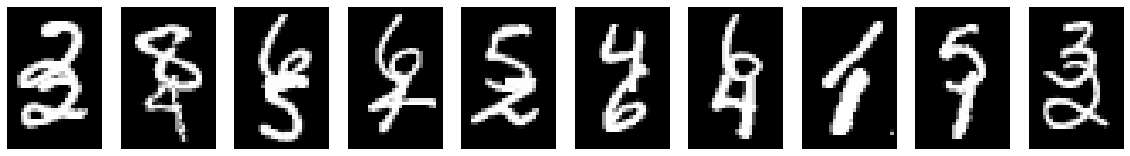

In [302]:
plotImg(X_train_dev[:10],1,10)

In [242]:
X_train, y_train, X_dev, y_dev = splitData(X_train_dev, y_train_dev, True)

In [339]:
# Paras:
batch_size = 64
n_epoch = 10

# model:
mlp = MLP(img_rows * img_cols)
cnn = CNN(img_rows * img_cols)

# optimize: SGD, Adam
sgd = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
adadelta = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)

In [323]:
# Split dataset into batches
train_batches = batchifyData(X_train, y_train, batch_size, True)
dev_batches = batchifyData(X_dev, y_dev, batch_size, True)
test_batches = batchifyData(X_test, y_test, batch_size, True)

In [340]:
def runModel(model, optimizer, is_overlap):   
    # train model
    train_dev_loss_acc = trainModel(train_batches, dev_batches, model, optimizer, is_overlap, n_epoch)
    
    # Evaluate the model on test data
    test_loss, test_acc, test_errors = runEpoch(test_batches, model.eval(), None, is_overlap)
    print()
    if is_overlap:
        print('Test loss1: {:.6f}  accuracy1: {:.6f}  loss2: {:.6f}   accuracy2: {:.6f}'.format(test_loss[0], test_acc[0], test_loss[1], test_acc[1]))
    else:
        print("Loss on test set:"  + str(test_loss) + " Accuracy on test set: " + str(test_acc))
    return train_dev_loss_acc, test_loss, test_acc, test_errors

In [343]:
# Baseline
train_dev_loss_acc, test_loss, test_acc, test_errors = runModel(mlp, sgd, True)


  0%|          | 0/10 [00:00<?, ?it/s]

-------------
Epoch 1:




 10%|█         | 1/10 [00:12<01:53, 12.61s/it]

Train | loss1: 2.304878  accuracy1: 0.099950 | loss2: 2.309226  accuracy2: 0.090664
Valid | loss1: 2.303549  accuracy1: 0.107359 | loss2: 2.309293  accuracy2: 0.085938
-------------
Epoch 2:




 20%|██        | 2/10 [00:26<01:44, 13.05s/it]

Train | loss1: 2.304878  accuracy1: 0.099950 | loss2: 2.309226  accuracy2: 0.090664
Valid | loss1: 2.303549  accuracy1: 0.107359 | loss2: 2.309293  accuracy2: 0.085938
-------------
Epoch 3:




 30%|███       | 3/10 [00:39<01:30, 12.87s/it]

Train | loss1: 2.304878  accuracy1: 0.099950 | loss2: 2.309226  accuracy2: 0.090664
Valid | loss1: 2.303549  accuracy1: 0.107359 | loss2: 2.309293  accuracy2: 0.085938
-------------
Epoch 4:




 40%|████      | 4/10 [00:52<01:17, 12.94s/it]

Train | loss1: 2.304878  accuracy1: 0.099950 | loss2: 2.309226  accuracy2: 0.090664
Valid | loss1: 2.303549  accuracy1: 0.107359 | loss2: 2.309293  accuracy2: 0.085938
-------------
Epoch 5:



KeyboardInterrupt: 

In [306]:
x_err, y1_err, y2_err, pred1_err, pred2_err = test_errors

In [309]:
36/4000

0.009

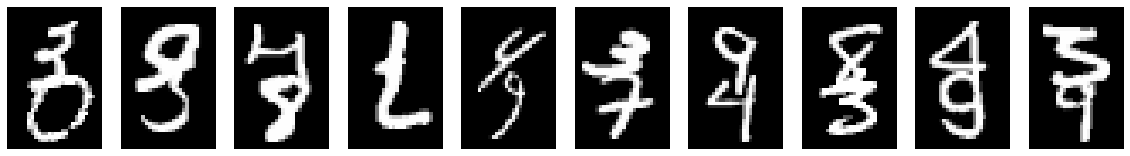

True upper labels:              [3 9 4 1 4 3 9 8 4 3]
True lower labels:              [0 3 8 2 9 7 4 3 9 9]

Wrongly Predicted upper labels: [5 8 9 8 5 9 4 5 9 5]
Wrongly Predicted lower labels: [5 5 5 6 3 4 9 8 8 4]

Wrong labels in total:          36


In [308]:
plotImg(np.array(test_errors[0])[:10],1,10)
print('True upper labels:              '+str(np.array(test_errors[1])[:10]))
print('True lower labels:              '+str(np.array(test_errors[2])[:10]))
print()
print('Wrongly Predicted upper labels: '+str(np.array(test_errors[3])[:10]))
print('Wrongly Predicted lower labels: '+str(np.array(test_errors[4])[:10]))
print()
print('Wrong labels in total:          '+str(len(test_errors[0])))

In [313]:
len(test_errors[1])

36

In [317]:
train_dev_loss_acc

2

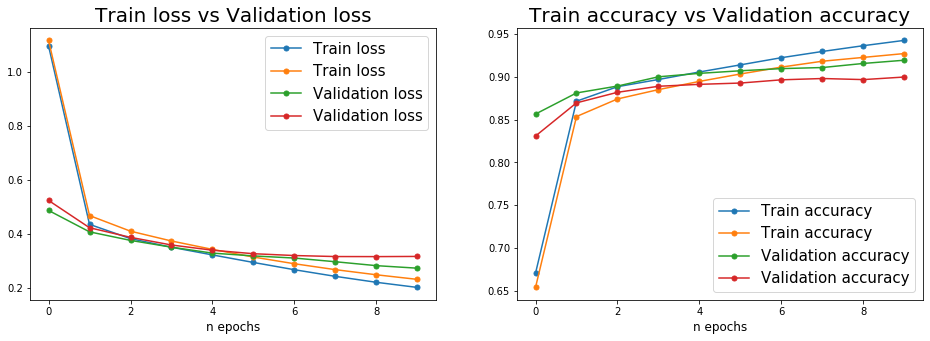

In [316]:
plotRes(train_dev_loss_acc) 